# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Amaury Combes"
sciper1 = 235400
student2 = "Vincenzo Bazzucchi"
sciper2 = 249733

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import json
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

import itertools
import pickle

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
SEED = sciper1 + sciper2
np.random.seed(SEED)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


In [3]:
REUSE = True

### Plotting

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [5]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [6]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

In [7]:
x_test.shape

(12735, 256)

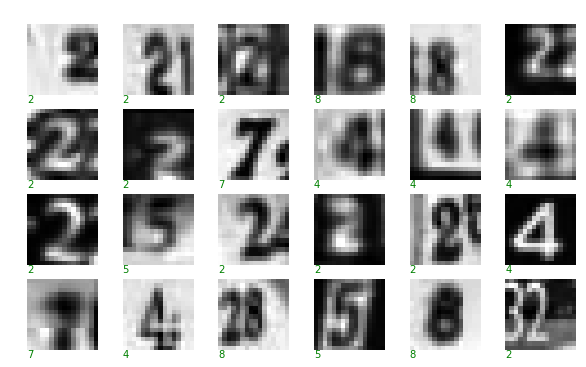

In [8]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [9]:
y_test_class = np.copy(y_test)

In [10]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [11]:
model = Sequential([
    Dense(y_train.shape[1], input_shape=(x_train.shape[1],), activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.1), #find params
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, batch_size=128,
)

Train on 35565 samples, validate on 12735 samples
Epoch 1/50
35565/35565 [==============================] - 1s 17us/step - loss: 1.5736 - acc: 0.3033 - val_loss: 1.5512 - val_acc: 0.3519
Epoch 2/50
35565/35565 [==============================] - 0s 12us/step - loss: 1.5517 - acc: 0.3225 - val_loss: 1.5453 - val_acc: 0.3647
Epoch 3/50
35565/35565 [==============================] - 0s 12us/step - loss: 1.5403 - acc: 0.3308 - val_loss: 1.5434 - val_acc: 0.3690
Epoch 4/50
35565/35565 [==============================] - 0s 14us/step - loss: 1.5334 - acc: 0.3396 - val_loss: 1.5400 - val_acc: 0.3596
Epoch 5/50
35565/35565 [==============================] - 0s 12us/step - loss: 1.5285 - acc: 0.3436 - val_loss: 1.5412 - val_acc: 0.3654
Epoch 6/50
35565/35565 [==============================] - 0s 12us/step - loss: 1.5250 - acc: 0.3465 - val_loss: 1.5417 - val_acc: 0.3676
Epoch 7/50
35565/35565 [==============================] - 0s 14us/step - loss: 1.5216 - acc: 0.3505 - val_loss: 1.5475 - val_acc

In [12]:
for metric, value in zip(model.metrics_names, model.evaluate(x_test, y_test)):
    print(metric, '=', value)

12735/12735 [==============================] - 0s 23us/step
loss = 1.56923644853
acc = 0.36890459364


The validation loss is constant around $\approx 1.50$

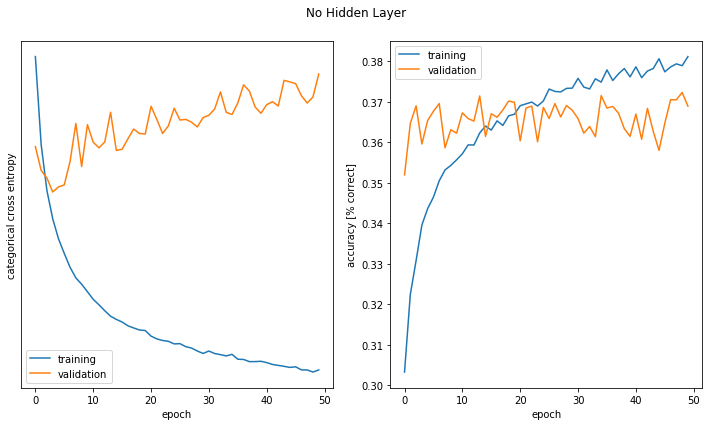

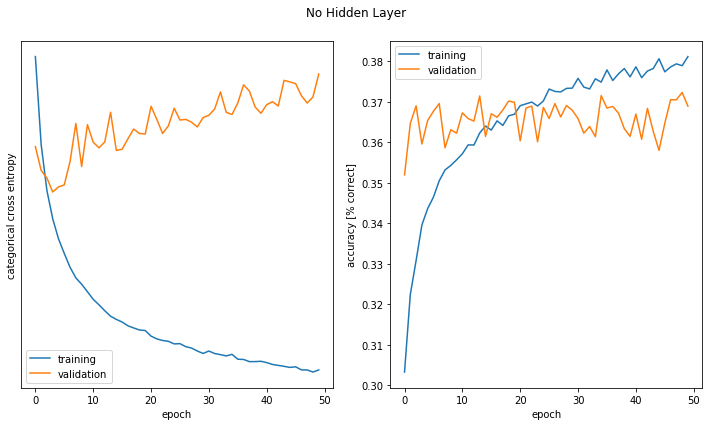

In [13]:
plot_history(history, "No Hidden Layer") # if do not store in var is displayed twice...

In [14]:
y_hat = model.predict_classes(x_test)

In [15]:
misclassified_indices = np.where(y_hat != y_test_class)[0]

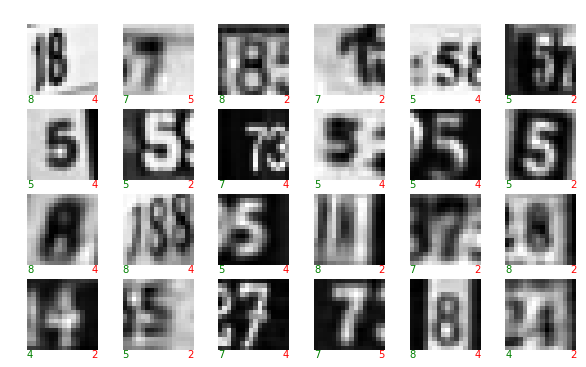

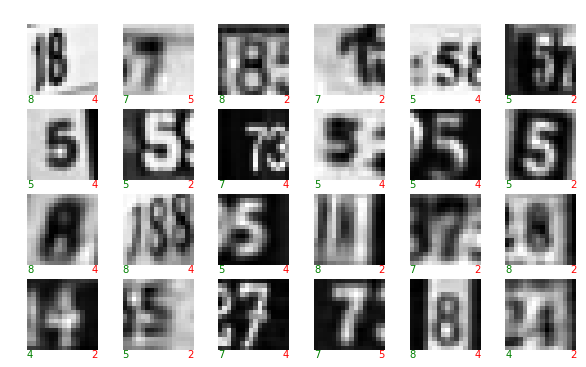

In [16]:
plot_some_samples(
    x_test[misclassified_indices],
    y_test_class[misclassified_indices],
    y_hat[misclassified_indices],
    label_mapping=subset_of_classes
)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

#### Question 1

In [17]:
model = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.01),
    metrics=['accuracy']
)

historySGD = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


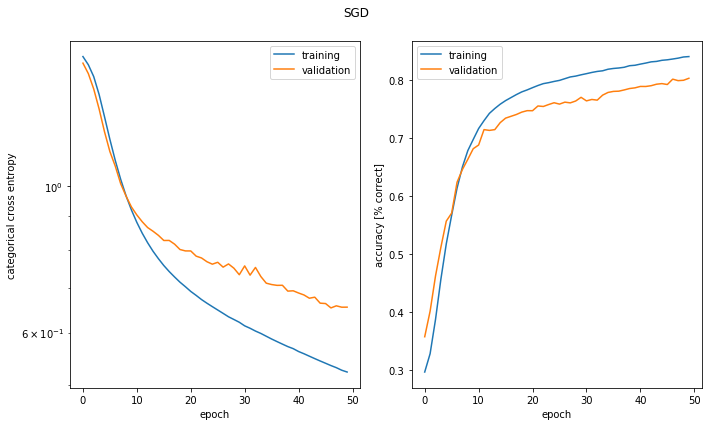

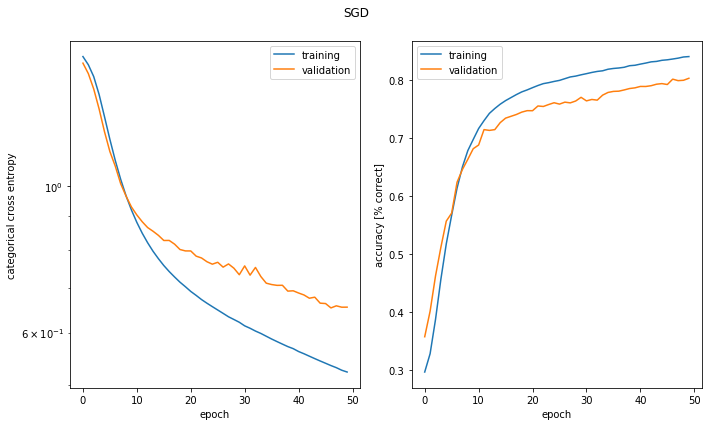

In [19]:
plot_history(historySGD, "SGD") # if do not store in var is displayed twice...

#### Question 2

In [20]:
LARGE_RATE = 0.9
SMALL_RATE = 10**(-6)

In [21]:
sgd_test_rate = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

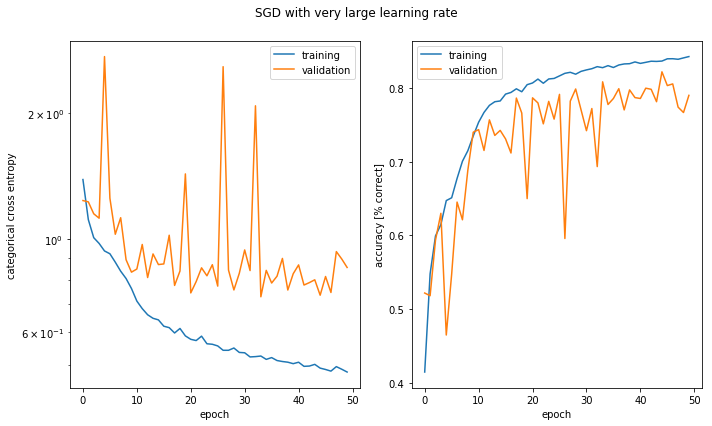

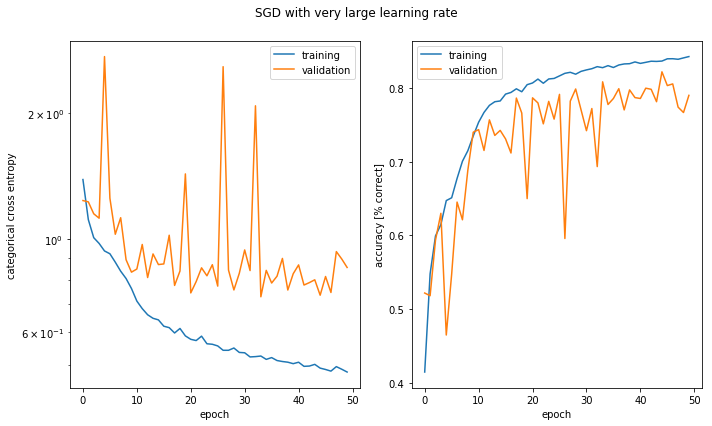

In [22]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=LARGE_RATE),
    metrics=['accuracy']
)

plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very large learning rate")

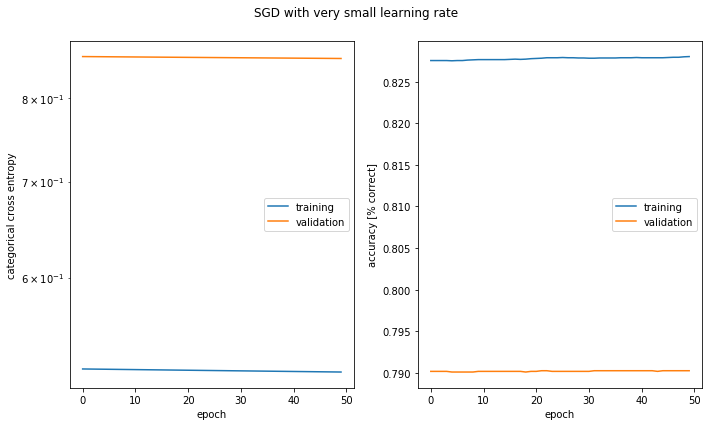

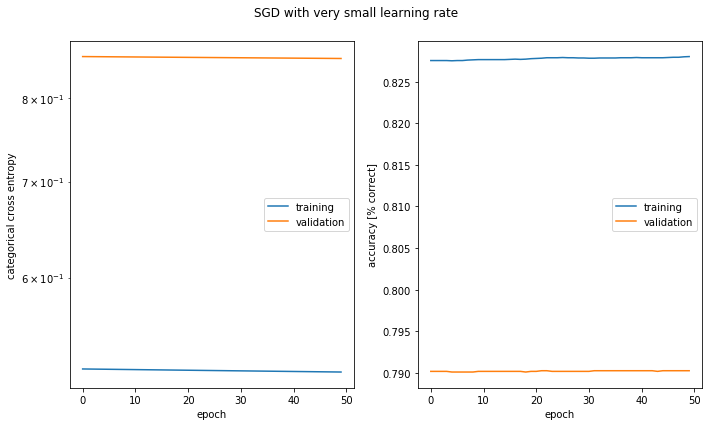

In [23]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=SMALL_RATE),
    metrics=['accuracy']
)

plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very small learning rate")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The validation error and accuracy are very "unstable", the search for the optimal value goes in the wrong direction many times

B) The improvement is very slow but constant: we would need many more epochs to reach the best result obtained with the larger learning rate

#### Question 3

In [24]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

historyAdam = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

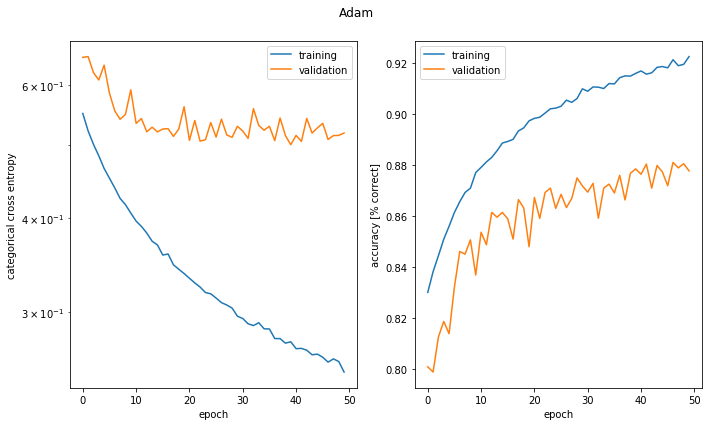

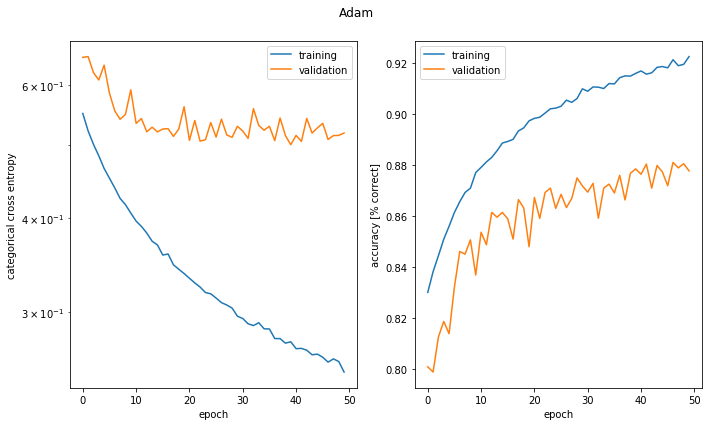

In [25]:
plot_history(historyAdam, "Adam") # if do not store in var is displayed twice...

Using the same learning rate with Adam and SGD does not allow Adam to improve its accuracy, therefore we changed it here

#### Question 4

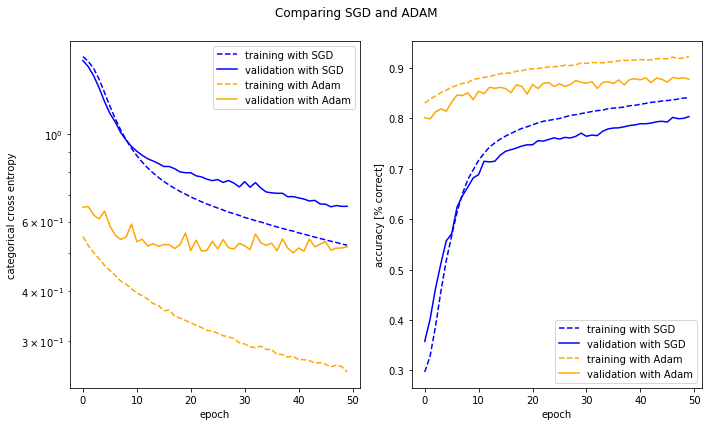

In [26]:
fig, ax1, ax2 = prepare_standardplot("Comparing SGD and ADAM", 'epoch')
ax1.plot(historySGD.history['loss'], label = "training with SGD", linestyle='--', c='b')
ax1.plot(historySGD.history['val_loss'], label = "validation with SGD", linestyle='-', c='b')
ax2.plot(historySGD.history['acc'], label = "training with SGD", linestyle='--', c='b')
ax2.plot(historySGD.history['val_acc'], label = "validation with SGD", linestyle='-', c='b')

ax1.plot(historyAdam.history['loss'], label = "training with Adam", linestyle='--', c='orange')
ax1.plot(historyAdam.history['val_loss'], label = "validation with Adam", linestyle='-', c='orange')
ax2.plot(historyAdam.history['acc'], label = "training with Adam", linestyle='--', c='orange')
ax2.plot(historyAdam.history['val_acc'], label = "validation with Adam", linestyle='-', c='orange')
finalize_standardplot(fig, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [27]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

historyAdam = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=60,
    verbose=0
)

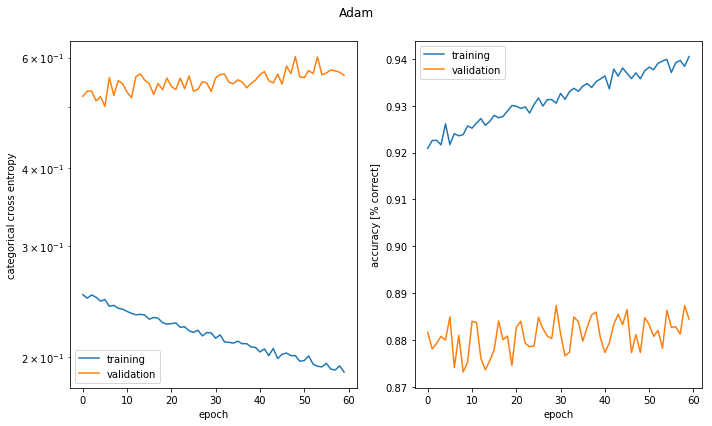

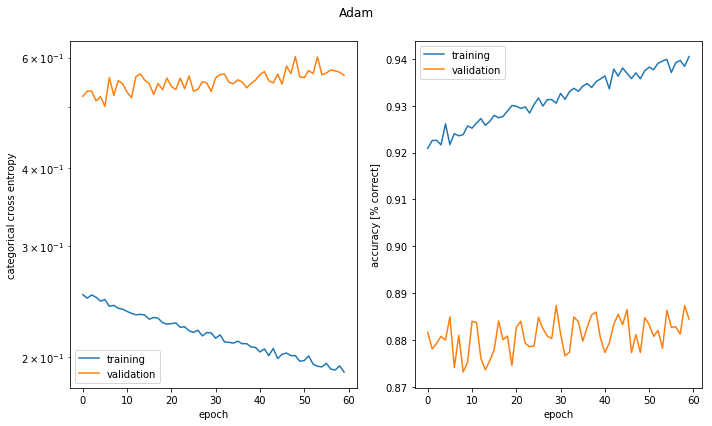

In [28]:
plot_history(historyAdam, "Adam")

The training we ran before was already overfitting: we can clearly see that the training error keeps decreasing while the validation error stays stable. We can see the same pattern observing the accuracy: the training accuracy keeps increasing while the validation accuracy is mostly stable

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: After epoch 20 we clearly see that the validation error stays stable or increases while the training error keeps decreasing

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: We observe that the decrease of training loss is parallel to the decrease of validation loss even if the rate of the two is different. Moreover the decrease of training loss causes a drecrease in validation loss, the same cannot be said for the accuracy: while we observe a stedy increase in training accuracy, the validation accuracy does not follow the same trend. This is due to the thresholding used to predict the labels.

As discussed in the forum, we should not use `keras.callbacks.EarlyStopping`. Therefore we implemented early stopping as described in the Deeplearning book: each time the validation accuracy improves, we take a snapshot of the model weights

In [29]:
class RealEarlyStopper(keras.callbacks.Callback):
    def __init__(self, set_best_at_end=True):
        self._best_score = -1
        self._best_weights = None
        self._set_best_at_end = set_best_at_end
    
    def on_epoch_end(self, epoch=None, logs={}):
        valacc = logs['val_acc']
        if valacc > self._best_score:
            self._best_score = valacc
            self._best_weights = [layer.get_weights() for layer in self.model.layers]
        
    def on_train_end(self, logs={}):
        if not self._set_best_at_end:
            return
        print('Restoring the model parameters giving best validation accuracy: {}'.format(self._best_score))
        for layer, best_weights in zip(self.model.layers, self._best_weights):
            layer.set_weights(best_weights)

In [30]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

historyAdam = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=75,
    verbose=0,
    callbacks=[RealEarlyStopper()]
)

Restoring the model parameters giving best validation accuracy: 0.8924224577981629


## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

As we observed from our previous plots, the Adam optimizer converges much quicker than the SGD one. Therefore we will use it here. We saw that the model start to overfit at around 20 so we will train it for 35 epochs.

As from the hint we do not have to take care of the random initialization of parameters: without specifying the same seed we have different random weights at each call.

As we want to investigate the **best validation loss and accuracy** we use our previously defined RealEarlyStopper

In [ ]:
def get_flat_model_result(hidden_neurons, early_stopping):
    m = Sequential([
        Dense(
            hidden_neurons, input_shape=(x_train.shape[1],),
            activation="relu",
            bias_initializer="zeros"
        ),
        Dense(
            y_train.shape[1],
            activation="softmax",
        )
    ])
    
    m.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=0.01),
        metrics=['accuracy']
    )
    
    h = m.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        verbose=0,
        callbacks=[RealEarlyStopper(True)] if early_stopping else None
        )
    
    return m.evaluate(x_test, y_test, verbose=0)

#### Question 1

In [ ]:
hidden_neurons = [5, 10, 50, 100, 175, 250, 400, 550, 775, 970]

In [ ]:
if REUSE:
    raise BaseException('Already Computed')

stats = []
for idx, hid in enumerate(hidden_neurons):
    stats.append(get_flat_model_result(hid, False))
    print("Completed train {}/{}".format(idx+1, N))
    
with open('exercise4-q1.json', 'w') as f:
    json.dump(stats, f)

In [ ]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')

with open('exercise4-q1.json', 'r') as f:
    stats = json.load(f)

#### Question 2

In [ ]:
if REUSE:
    raise BaseException('Already Computed')

try_per_model = 7

stats = []

for idx, hid in enumerate(hidden_neurons):
    for _ in range(try_per_model):
        
        stats.append(get_flat_model_result(hid, False))
        
    print("Completed train {}/{}".format(idx+1, N))
    
with open('exercise4-q2.json', 'w') as f:
    json.dump(stats, f)

In [ ]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')

with open('exercise4-q2.json', 'r') as f:
    stats = json.load(f)

#### Question 3

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2)#, sharey=True)

losses, accuracies = zip(*stats)

ax_loss.boxplot(losses)
ax_loss.set_title("Validation loss")
#ax_loss.set_yticklabels(hidden_neurons) # I am not sure it makes any sense: to build boxplot points are not kept in the same order


ax_acc.boxplot(accuracies)
ax_acc.set_title("Validation accuracy")
#ax_acc.set_yticklabels(hidden_neurons)

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2, sharey=True)

ax_loss.plot(hidden_neurons, losses)
ax_loss.set_title("Validation loss")
ax_acc.plot(hidden_neurons, accuracies)
ax_acc.set_title("Validation accuracy")

#### Question 4

In [ ]:
if REUSE:
    raise BaseException('Already Computed')

try_per_model = 4

stats = []

for idx, hid in enumerate(hidden_neurons):
    for _ in range(try_per_model):
        
        stats.append(get_flat_model_result(hid, True))
        
    print("Completed train {}/{}".format(idx+1, N))
    
with open('exercise4-q4.json', 'w') as f:
    json.dump(stats, f)

In [ ]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')

with open('exercise4-q4.json', 'r') as f:
    stats = json.load(f)

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

#### Question 1

As we learnt during the lectures, we use the ReLU activation in the hidden layers and and the softmax at the end.
We apply a different dropout probability to the input layer and to the hidden layers 

In [80]:
def dense_factory(input_, output, weight_regularizer, bias_regularizer, activation):
    return Dense(
        output,
        input_shape=(input_,),
        activation=activation,
        kernel_regularizer=weight_regularizer,
        bias_regularizer=bias_regularizer
    )

def model_factory(units, layers, batch_normalization, weight_regularizer, bias_regularizer, dropout=None, input_dropout=None):
    model_builder = Sequential()
    
    # Input layer
    model_builder.add(dense_factory(x_train.shape[1], units, weight_regularizer, bias_regularizer, 'relu')) 
    if dropout is not None:
        model_builder.add(Dropout(input_dropout))
        
    # Hidden layers
    for i in range(layers-1):
        model_builder.add(dense_factory((units,), units, weight_regularizer, bias_regularizer, 'relu'))
        
        if dropout is not None:
            model_builder.add(Dropout(dropout))
            
        if batch_normalization is not None:
            model_builder.add(BatchNormalization())
        
    # Output layer
    model_builder.add(dense_factory((units,), y_train.shape[1], weight_regularizer, bias_regularizer, 'softmax'))
    
    return model_builder

# Factories for required models
size_per_layer_1_hidden = 100
size_per_layer_2_hidden = 77
size_per_layer_3_hidden = 66
size_per_layer_4_hidden = 59

def model_1_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None, input_dropout=None):
    return model_factory(size_per_layer_1_hidden, 1, batch_normalization, weight_regularizer, bias_regularizer, dropout, input_dropout)

def model_2_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None, input_dropout=None):
    return model_factory(size_per_layer_2_hidden, 2, batch_normalization, weight_regularizer, bias_regularizer, dropout, input_dropout)

def model_3_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None, input_dropout=None):
    return model_factory(size_per_layer_3_hidden, 3, batch_normalization, weight_regularizer, bias_regularizer, dropout, input_dropout)

def model_4_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None, input_dropout=None):
    return model_factory(size_per_layer_4_hidden, 4, batch_normalization, weight_regularizer, bias_regularizer, dropout, input_dropout)

def compile_model(model, lr=0.001):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
def fit_model(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, iter_=35, verbose=0, batch_size=32):
    h = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=iter_,
        verbose=verbose
    )   
    return h

#### Confirm you result with the keras method model.summary()

In [ ]:
model_1_hidden_factory().summary()
model_2_hidden_factory().summary()
model_3_hidden_factory().summary()
model_4_hidden_factory().summary()

#### Question 2

In [ ]:
if REUSE:
    raise BaseException('Already Computed')

model_factories = [model_1_hidden_factory, model_2_hidden_factory, model_3_hidden_factory, model_4_hidden_factory]

try_per_model = 20

results = []

for i, factory in enumerate(model_factories):
    print('Training model', i + 1, '/', len(model_factories))
    
    curr_model_res = []
    
    for i in range(try_per_model):
        print('Inner step:', i+1, '/', try_per_model)
        
        model = factory()
        
        compile_model(model)
        
        h = fit_model(model, x_train, y_train, x_test, y_test, 50)
        
        curr_model_res.append(h)
        
    results.append(curr_model_res)
    
with open('ex5_histories.pkl', 'wb') as output:
    for result_history in results:
        pickle.dump(result_history, output, pickle.HIGHEST_PROTOCOL)

In [1]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')

# PUT HERE CODE TO READ PICKLE

NameError: name 'REUSE' is not defined

#### Plot summary statistics of the best validation loss and accuracy versus the number of hidden layers

In [ ]:
# Extract best loss and accuracy for each (model, training)
best_results = [[[min(res.history['val_loss']), max(res.history['val_acc'])] for res in model_res] for model_res in results]
best_val_loss = [[res[0] for res in model_res] for model_res in best_results]
best_val_acc = [[res[1] for res in model_res] for model_res in best_results]

with open('exercise5-q2.json', 'w') as f:
    json.dump(best_results, f)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(best_val_loss)
plt.title('Distribution of validation losses against number of hidden layers (fix # of params)')
plt.xlabel('Number of hidden layers')
plt.ylabel("Validation loss")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(best_val_acc)
plt.title('Distribution of validation accuracies against number of hidden layers (fix # of params)')
plt.xlabel('Number of hidden layers')
plt.ylabel("Validation accuracy")
plt.show()

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

#### Question 1

#### Tuning the regularizer parameters

An initial investigation gave good results for a bias regularizer of 0.8. We thus perform another grid search around this value.

#### Bias Reguarization

In [116]:
if REUSE:
    raise BaseException('Already Computed')

bias_regularizers_l1 = np.linspace(10**(-6), 10**(-4), 5)
bias_regularizers_l2 = np.linspace(10**(-6), 10**(-4), 5)


l1_bias_reg_history = {}

for l1_bias_reg in tqdm(bias_regularizers_l1):
    model = model_1_hidden_factory(bias_regularizer=keras.regularizers.l1(l1_bias_reg))
    compile_model(model)
    l1_bias_reg_history[('1', l1_bias_reg)] = fit_model(model).history
    
    model = model_4_hidden_factory(bias_regularizer=keras.regularizers.l1(l1_bias_reg))
    compile_model(model)
    l1_bias_reg_history[('4', l1_bias_reg)] = fit_model(model).history
    
l2_bias_reg_history = {}
    
for l2_bias_reg in tqdm(bias_regularizers_l2):
    model = model_1_hidden_factory(bias_regularizer=keras.regularizers.l2(l2_bias_reg))
    compile_model(model)
    l2_bias_reg_history[('1', l2_bias_reg)] = fit_model(model).history
    
    model = model_4_hidden_factory(bias_regularizer=keras.regularizers.l2(l2_bias_reg))
    compile_model(model)
    l2_bias_reg_history[('4', l2_bias_reg)] = fit_model(model).history
    
bias_reg_history = {'l1': l1_bias_reg_history, 'l2': l2_bias_reg_history}
with open('q6-bias_reg.pickle', 'wb') as f:
    pickle.dump(bias_reg_history, f)

BaseException: Already Computed

In [117]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')
    
with open('q6-bias_reg.pickle', 'rb') as f:
    bias_reg_history = pickle.load(f)
    l1_bias_reg_history = bias_reg_history['l1']
    l2_bias_reg_history = bias_reg_history['l2']

In [118]:
h4_bias_best_l1 = max(l1_bias_reg_history.keys(), key=lambda k: max(l1_bias_reg_history[('4', k[1])]['val_acc']))
h4_bias_best_l2 = max(l2_bias_reg_history.keys(), key=lambda k: max(l2_bias_reg_history[('4', k[1])]['val_acc']))

h1_bias_best_l1 = max(l1_bias_reg_history.keys(), key=lambda k: max(l1_bias_reg_history[('1', k[1])]['val_acc']))
h1_bias_best_l2 = max(l2_bias_reg_history.keys(), key=lambda k: max(l1_bias_reg_history[('1', k[1])]['val_acc']))

In [138]:
(
'Deeper model with L1 on biases has validation accuracy = {}'.format(l1_bias_reg_history[h4_bias_best_l1]['val_acc'][-1]),
'Deeper model with L2 on biases has validation accuracy = {}'.format(l2_bias_reg_history[h4_bias_best_l2]['val_acc'][-1]),
'Flat model with L1 on biases has validation accuracy = {}'.format(l1_bias_reg_history[h1_bias_best_l1]['val_acc'][-1]),
'Flat model with l2 on biases has validation accuracy = {}'.format(l2_bias_reg_history[h1_bias_best_l2]['val_acc'][-1])
)

('Deeper model with L1 on biases has validation accuracy = 0.8610129564239972',
 'Deeper model with L2 on biases has validation accuracy = 0.8569297212453557',
 'Flat model with L1 on biases has validation accuracy = 0.8610129564239972',
 'Flat model with l2 on biases has validation accuracy = 0.8639183352309019')

In both cases, the L2 regularization gave better results

#### Weight Regularization

In [120]:
if REUSE:
    raise BaseException('Already Computed')

weight_regularizers_l1 = np.linspace(10**(-6), 10**(-4), 5)
weight_regularizers_l2 = np.linspace(10**(-6), 10**(-4), 5)


l1_weight_reg_history = {}

for l1_weight_reg in tqdm(weight_regularizers_l1):
    model = model_1_hidden_factory(weight_regularizer=keras.regularizers.l1(l1_weight_reg))
    compile_model(model)
    l1_weight_reg_history[('1', l1_weight_reg)] = fit_model(model, verbose=1).history
    
    model = model_4_hidden_factory(weight_regularizer=keras.regularizers.l1(l1_weight_reg))
    compile_model(model)
    l1_weight_reg_history[('4', l1_weight_reg)] = fit_model(model, verbose=1).history
    
l2_weight_reg_history = {}
    
for l2_weight_reg in tqdm(weight_regularizers_l2):
    model = model_1_hidden_factory(weight_regularizer=keras.regularizers.l2(l2_weight_reg))
    compile_model(model)
    l2_weight_reg_history[('1', l2_weight_reg)] = fit_model(model, verbose=1).history
    
    model = model_4_hidden_factory(weight_regularizer=keras.regularizers.l2(l2_weight_reg))
    compile_model(model)
    l2_weight_reg_history[('4', l2_weight_reg)] = fit_model(model, verbose=1).history
    
weight_reg_history = {'l1' : l1_weight_reg_history, 'l2': l2_weight_reg_history}
with open('q6-weight_reg.pickle', 'wb') as f:
    pickle.dump(weight_reg_history, f)

BaseException: Already Computed

In [141]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')
    
with open('q6-weight_reg.pickle', 'rb') as f:
    weight_reg_history = pickle.load(f)
    l1_weight_reg_history = weight_reg_history['l1']
    l2_weight_reg_history = weight_reg_history['l2']

In [142]:
h4_weight_best_l1 = max(l1_weight_reg_history.keys(), key=lambda k: max(l1_weight_reg_history[('4', k[1])]['val_acc']))
h4_weight_best_l2 = max(l2_weight_reg_history.keys(), key=lambda k: max(l2_weight_reg_history[('4', k[1])]['val_acc']))

h1_weight_best_l1 = max(l1_weight_reg_history.keys(), key=lambda k: max(l1_weight_reg_history[('1', k[1])]['val_acc']))
h1_weight_best_l2 = max(l2_weight_reg_history.keys(), key=lambda k: max(l1_weight_reg_history[('1', k[1])]['val_acc']))

In [144]:
(
'Deeper model with L1 on weights has validation accuracy = {}'.format(l1_weight_reg_history[h4_weight_best_l1]['val_acc'][-1]),
'Deeper model with L2 on weights has validation accuracy = {}'.format(l2_weight_reg_history[h4_weight_best_l2]['val_acc'][-1]),
'Flat model with L1 on weights has validation accuracy = {}'.format(l1_weight_reg_history[h1_weight_best_l1]['val_acc'][-1]),
'Flat model with l2 on weights has validation accuracy = {}'.format(l2_weight_reg_history[h1_weight_best_l2]['val_acc'][-1])
)

('Deeper model with L1 on weights has validation accuracy = 0.8701217118225053',
 'Deeper model with L2 on weights has validation accuracy = 0.8678445229026726',
 'Flat model with L1 on weights has validation accuracy = 0.8545740086422933',
 'Flat model with l2 on weights has validation accuracy = 0.8628190027576921')

L1 gave better results for the deeper model while L2 regularization gave better results for the flat one

#### Batch Normalization

We use the default values for the batch normalization class

In [124]:
if REUSE:
    raise BaseException('Already Computed')

batch_norm_results = {}

batch_norm_model = model_1_hidden_factory(batch_normalization=not None)
compile_model(batch_norm_model)
batch_norm_results['1'] = fit_model(batch_norm_model, verbose=1).history

    
batch_norm_model = model_4_hidden_factory(batch_normalization=not None)
compile_model(batch_norm_model)
batch_norm_results['4'] = fit_model(batch_norm_model, verbose=1).history

with open('q6-batch_norm.pickle', 'wb') as f:
    pickle.dump(batch_norm_results, f)

BaseException: Already Computed

In [125]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')
    
with open('q6-batch_norm.pickle', 'rb') as f:
    batch_norm_results = pickle.load(f)

In [126]:
print('Final validation accuracy on flat model', batch_norm_results['1']['val_acc'][-1])
print('Final validation accuracy on deeper model', batch_norm_results['4']['val_acc'][-1])

Final validation accuracy on flat model 0.878680800877
Final validation accuracy on deeper model 0.84515115816


#### Dropout

The dropout probabilities used here are the ones suggested in the Deeplearning book: the probability that an input node disappears is $0.2$ and the probability that a hidden node disappears is $0.8$

In [127]:
if REUSE:
    raise BaseException('Already Computed')

dropout_results = {}

dropout_model = model_1_hidden_factory(dropout=0.8, input_dropout=0.2)
compile_model(dropout_model)
dropout_results['1'] = fit_model(dropout_model, verbose=1).history

    
dropout_model = model_4_hidden_factory(dropout=0.8, input_dropout=0.2)
compile_model(dropout_model)
dropout_results['4'] = fit_model(dropout_model, verbose=1).history

with open('q6-dropout.pickle', 'wb') as f:
    pickle.dump(dropout_results, f)

BaseException: Already Computed

In [128]:
if not REUSE:
    raise BaseException('Values were not computed, cannot load from file')
    
with open('q6-dropout.pickle', 'rb') as f:
    dropout_results = pickle.load(f)

In [129]:
print('Final validation accuracy on flat model', dropout_results['1']['val_acc'][-1])
print('Final validation accuracy on deeper model', dropout_results['4']['val_acc'][-1])

Final validation accuracy on flat model 0.862661955176
Final validation accuracy on deeper model 0.419630938359


We can now use these results to build two better models

In [145]:
# Flat model
flat_model = model_1_hidden_factory(
    dropout=0.8,
    input_dropout=0.2,
    batch_normalization=not None,
    bias_regularizer=keras.regularizers.l2(h1_bias_best_l2[1]),
    weight_regularizer=keras.regularizers.l2(h1_weight_best_l2[1])
)

compile_model(flat_model)
h = fit_model(dropout_model, verbose=1)

Train on 35565 samples, validate on 12735 samples
Epoch 1/35
35565/35565 [==============================] - 10s 274us/step - loss: 1.4034 - acc: 0.4106 - val_loss: 1.4879 - val_acc: 0.4152
Epoch 2/35
35565/35565 [==============================] - 6s 162us/step - loss: 1.4047 - acc: 0.4094 - val_loss: 1.5508 - val_acc: 0.4287
Epoch 3/35
35565/35565 [==============================] - 5s 150us/step - loss: 1.4027 - acc: 0.4110 - val_loss: 1.4960 - val_acc: 0.4137
Epoch 4/35
35565/35565 [==============================] - 5s 145us/step - loss: 1.4009 - acc: 0.4109 - val_loss: 1.4815 - val_acc: 0.4209
Epoch 5/35
35565/35565 [==============================] - 5s 150us/step - loss: 1.4105 - acc: 0.4073 - val_loss: 1.5259 - val_acc: 0.4016
Epoch 6/35
35565/35565 [==============================] - 5s 145us/step - loss: 1.4008 - acc: 0.4113 - val_loss: 1.4803 - val_acc: 0.4265
Epoch 7/35
35565/35565 [==============================] - 6s 156us/step - loss: 1.4010 - acc: 0.4140 - val_loss: 1.5232 -

In [113]:
h.history['val_acc'][-1]

0.42685512367491169

In [114]:
# Deeper model
deeper_model = model_4_hidden_factory(
    dropout=0.8,
    input_dropout=0.2,
    batch_normalization=not None,
    bias_regularizer=keras.regularizers.l2(h4_bias_best_l2[1]),
    weight_regularizer=keras.regularizers.l1(h4_weight_best_l1[1])
)

compile_model(deeper_model)
h = fit_model(deeper_model, verbose=1)

Train on 35565 samples, validate on 12735 samples
Epoch 1/35
35565/35565 [==============================] - 13s 355us/step - loss: 1.8197 - acc: 0.2523 - val_loss: 1.6611 - val_acc: 0.3258
Epoch 2/35
35565/35565 [==============================] - 7s 200us/step - loss: 1.6766 - acc: 0.2932 - val_loss: 1.6508 - val_acc: 0.3258
Epoch 3/35
35565/35565 [==============================] - 7s 192us/step - loss: 1.6638 - acc: 0.2963 - val_loss: 1.6379 - val_acc: 0.3258
Epoch 4/35
35565/35565 [==============================] - 8s 215us/step - loss: 1.6514 - acc: 0.2969 - val_loss: 1.6281 - val_acc: 0.3258
Epoch 5/35
35565/35565 [==============================] - 7s 204us/step - loss: 1.6390 - acc: 0.2970 - val_loss: 1.6154 - val_acc: 0.3258
Epoch 6/35
35565/35565 [==============================] - 7s 201us/step - loss: 1.6270 - acc: 0.2971 - val_loss: 1.6061 - val_acc: 0.3258
Epoch 7/35
35565/35565 [==============================] - 7s 205us/step - loss: 1.6178 - acc: 0.2974 - val_loss: 1.5970 -

In [115]:
h.history['val_acc'][-1]

0.32579505300353356

We see that the different regularizers conflict with each other. Trying different combinations also yields mediocre results. Therefore we decided that the enhanced model uses only one regularizer, the one yielding the best validation score:
 - L1 Weight regularizer for the deeper model: `validation accuracy = `$0.8701217118225053$
 - Batch normalization regularizer for the flat model: `validation accuracy = `$0.878680800877$

#### Question 2

In [158]:
class History:
    def __init__(self, h):
        self.history = h
        
def emulate_keras_history(history_obj):
    return History(history_obj)

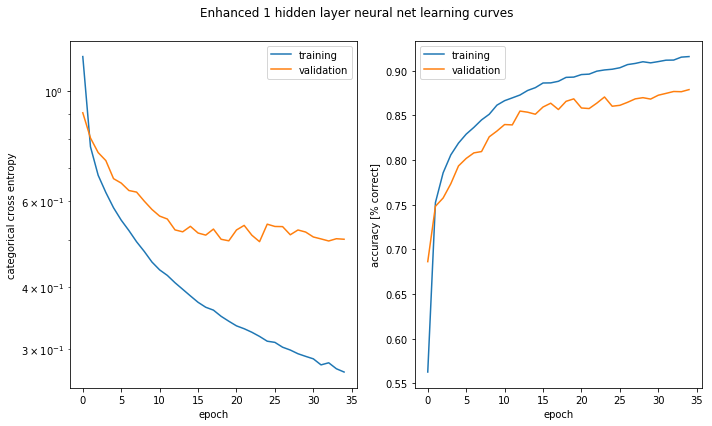

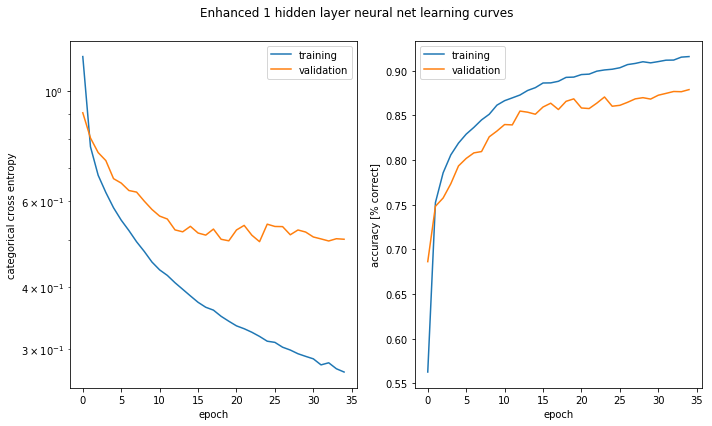

In [159]:
plot_history(
    emulate_keras_history(batch_norm_results['1']),
    'Enhanced 1 hidden layer neural net learning curves'
)

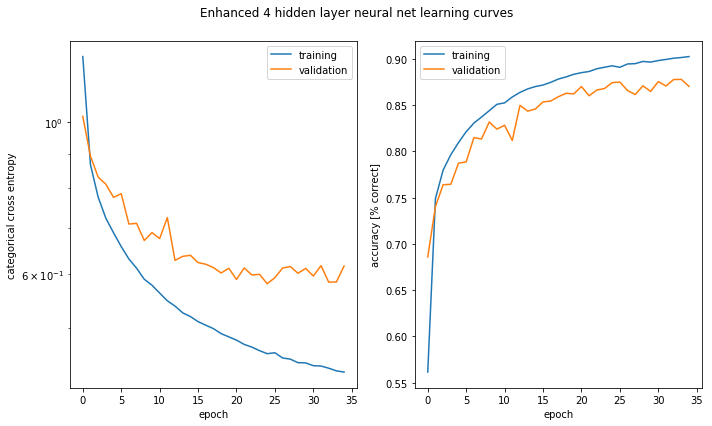

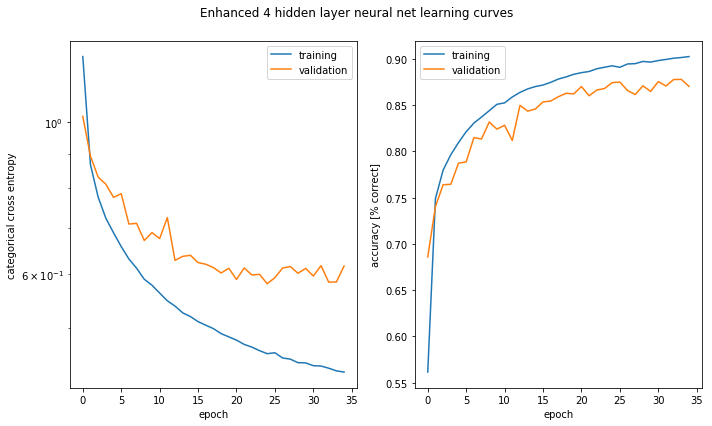

In [160]:
plot_history(
    emulate_keras_history(l1_weight_reg_history[h4_weight_best_l1]),
    'Enhanced 4 hidden layer neural net learning curves'
)

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [ ]:
train_tensor = np.reshape(x_train, (x_train.shape[0], 16, 16, 1))
test_tensor = np.reshape(x_test, (x_test.shape[0], 16, 16, 1))

In [ ]:
cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_tensor.shape[1:]),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.Adadelta(),
           metrics=['accuracy'])

In [ ]:
cnn.fit(
    train_tensor, y_train,
    validation_data=(test_tensor, y_test),
    epochs=20    
)